<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/math-and-architectures-of-deep-learning/02-introduction-to-vectors-calculus/02_gradient_computation_for_non_linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Gradient Computation for non-linear model

In machine learning, we identify the input and output variables
pertaining to the problem at hand and cast the problem as
generating outputs from input variables. All the inputs are
represented together by the vector $\vec{x}$. Sometimes there
are multiple outputs, sometimes single output. Accordingly,
we have an output vector $\vec{y}$ or output scalar $y$.
Let us denote the function that generates the output from input
 vector as $f$, i.e., $y = f\left(\vec{x}\right)$.

In real life problems, we do not know $f$. The crux of machine
learning is to estimate $f$ from a set of observed inputs
$\vec{x}_{i}$ and their corresponding outputs $y_{i}$.
Each observation can be depicted as a pair $\langle\vec{x}_{i}, y_{i}\rangle$.
We model the unknown function $f$ with a known function $\phi$.
$\phi$ is a parameterized function. Alhtough the nature of $\phi$
is known, its parameter values are unknown. These parameter values
 are "learnt" via training. This means, we estimate the parameter
values such that the overall error on the observations is minimized.

If $\vec{w}, b$ denotes the current set of parameters (weights, bias), then the model will
output $\phi\left(\vec{x}_{i}, \vec{w}, b\right)$ on the observed input $\vec{x}_{i}$.
Thus the error on this $i^{th}$ observation is $e_{i}^{2}=\left(\phi\left(\vec{x}_{i}, \vec{w}, b\right) - y_{i}\right)^{2}$.
We can batch up several observations and add up the error into a batch error
$L = \sum_{i=0}^{i=N}\left(e^{\left(i\right)}\right)^{2}$.

The error is a function of the parameter set $\vec{w}$.
The question is: how do we adjust $\vec{w}$ so that the error $e_{i}^{2}$ decreases.
We know a function's value changes most when we move along the direction of
of the gradient of the parameters. Hence, we adjust the parameters
$\vec{w}, b$ as
$\begin{bmatrix}
\vec{w}\\b
\end{bmatrix} = \begin{bmatrix}
\vec{w}\\b
\end{bmatrix} - \mu \nabla_{\vec{w}, b}L\left(\vec{w}, b\right)$.
Each adjustment reduces the error. Starting from a random set of parameter values
doing this "sufficiently" large number of times yields the desired model.

A simple and popular model $\phi$ is the linear function (predicted value is
dot product between input and parameters plus bias):
$\tilde{y}_{i} = \phi\left(\vec{x}_{i}, \vec{w}, b\right) = \vec{w}^{T}\vec{x} + b
= \sum_{j}w_{j}x_{j} + b$.
In the example below, this is the model architecture used.

Thus 
\begin{align*}
L &= \sum_{i=0}^{i=N}\left(e^{\left(i\right)}\right)^{2}\\
  &= \sum_{i=0}^{i=N}\left(\vec{w}^{T}\vec{x} + b - y_{i}\right)^{2}\\
\nabla_{\vec{w}, b}L &\propto \sum_{i=0}^{i=N}\left(\vec{w}^{T}\vec{x}_{i} + b - y_{i}\right)\vec{x}_{i} \\
                     &\propto \sum_{i=0}^{i=N}\left(\tilde{y}_{i} - y_{i}\right)\vec{x}_{i}
\end{align*}
Our initial implementation will simply mimic this formula.
For more complicated models $\phi$ (with millions of parameters and non-linearities)
we cannot obtain closed form gradients like this.

The next example, based on NumPy and PyTorch, relies on PyTorch's
autograd (automatic gradient computation) which does not have this limitation.

##Setup

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def update_parameters(params, learning_rate):
  """
  Update the current weight and bias values
  from gradient values.
  """
  # Don't track gradients while updating params
  with torch.no_grad():
      for i, p in enumerate(params):
          params[i] = p - learning_rate * p.grad
          
  # Restore tracking of gradient for all params
  for i in range(len(params)):
      params[i].requires_grad = True


def draw_line(m, c, min_x=0, max_x=10, color='magenta', label=None):
  """
  Plots y = mx + c from interval (min_x to max_x)
  """
  # linspace creates an array of equally spaced
  # values between the specified min and max in 
  # specified number of steps.
  x = np.linspace(min_x, max_x, 100)
  y = m*x + c
  
  plt.plot(x, y, color=color, 
            label='y=%0.2fx+%0.2f'%(m, c)\
                if not label else label)
    
def draw_parabola(w0, w1, w2,  min_x=0, max_x=10, color='magenta', label=None):
  """
  Plots y = w0 + w1*x + w2*x^2 from interval
  (min_x to max_x)
  """
  x = np.linspace(min_x, max_x, 100)
  y = w0 + w1*x +  w2* (x**2)
  plt.plot(x, y, color=color, 
            label='y=%0.2f+ %0.2fx + %0.2fx^2'
            %(w0, w1, w2) if not label else label)
    
def draw_subplot(pos, step, true_draw_func, true_draw_params, pred_draw_func, pred_draw_params):
  """
  Plots the curves corresponding to a specified pair of functions.
  We use it to plot
  (i) the true function (used to generate the observations
      that we are trying to predict with a trained mode) vis a vis
  (ii) the model function (used to makes the predictions)
        When the predictor is good, the two plots should more or less coincide.
  Thus this is used to visualize the goodness of the current approximation.
  """
  plt.subplot(2, 2, pos)
  plt.title('Step %d'%(step))
  true_draw_func(**true_draw_params)
  pred_draw_func(**pred_draw_params)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend(loc='upper left')

##Non-linear Models

For scalability, we can use
PyTorch, where gradients are computed via automatic differentiation.

We dont need to worry about how to compute the gradients-they just construct the model function. 

Once the function is specified, PyTorch figures out how to compute
its gradient through a technology called autograd.

Autograd is the technology in pytorch for automatic gradient computation.

One explicitly tells pytorch to track gradients with respect to a
variable by setting `requires_grad = True` when creating the variable.

But what happens if the underlying output function is non-linear?

Here the input data is generated from non-linear function $y = x^2 -x + 2$.

As before, our observations (training data) comprise
 various values of `x` and corresponding values of `y` computed from this function.

We will add some noise to the computed values to generate the observed value.

We will train a model $y_obs = w_0*x^2 + w_1*x + b$ and see if the learnt parameters come out close to the expected values $w_0 = 1, w_1 = -1 b = 2$.

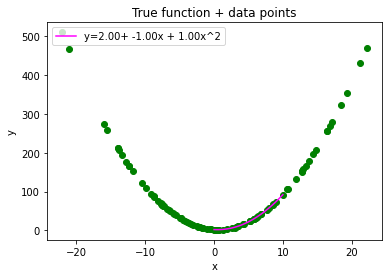

Step 0: w = tensor([0.3932]) b = tensor([-0.2148]) 
MSE Error = 9570.197265625
Gradient of w: tensor([-116.9342]) 
Gradient of b: tensor([-195.6548])
Step 100: w = tensor([40.7239]) b = tensor([67.2667]) 
MSE Error = 38.96216583251953
Gradient of w: tensor([-7.4611]) 
Gradient of b: tensor([-12.4839])
Step 200: w = tensor([43.2972]) b = tensor([71.5725]) 
MSE Error = 0.1586260050535202
Gradient of w: tensor([-0.4761]) 
Gradient of b: tensor([-0.7966])
Step 300: w = tensor([43.4614]) b = tensor([71.8472]) 
MSE Error = 0.0006466379854828119
Gradient of w: tensor([-0.0304]) 
Gradient of b: tensor([-0.0509])
Step 400: w = tensor([43.4719]) b = tensor([71.8647]) 
MSE Error = 2.6437996893946547e-06
Gradient of w: tensor([-0.0019]) 
Gradient of b: tensor([-0.0033])
Step 500: w = tensor([43.4726]) b = tensor([71.8658]) 
MSE Error = 2.498961748642614e-08
Gradient of w: tensor([-0.0002]) 
Gradient of b: tensor([-0.0003])
Step 600: w = tensor([43.4726]) b = tensor([71.8658]) 
MSE Error = 2.498961

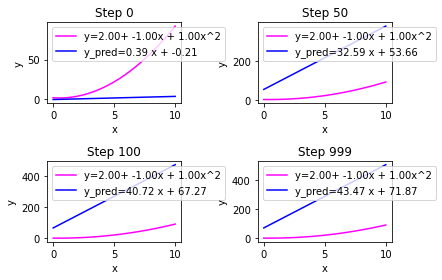

True function: y = 1.5*x + 2.73
Learnt function: y_pred = 43.47256851196289*x + 71.86576843261719
Clearly the model is not converging to anything
close to the desired/true function.
Our model architecture is inadequate


In [3]:
torch.manual_seed(42)

# generate random input values
N = 100
x = 10 * torch.randn(N, 1)

# Compute function outputs
y = x ** 2 - x + 2.0

# Add random noise to get the observed value of y
y_obs = y + (0.5 * torch.randn(N, 1) - 0.25)

# Plot the true function and the data points
plt.scatter(x.data, y_obs.data, color="green")
draw_parabola(2, -1, 1)
plt.title('True function + data points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

# First, let us try a linear model y_pred = wx + b
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
# combine bias and weights matrix
params = [b, w]

# Training: repeatative adjustment of parameters via gradient.
num_steps = 1000
learning_rate = 1e-2

plt.figure()

# Train model iteratively
i = 1
plot_steps = [0, 50, 100, 999]
for step in range(num_steps):
  # linear model
  y_pred = params[0] + params[1] * x

  # Periodically plot the true function and current approximation to check how we are doing
  if step in plot_steps:
    draw_subplot(i, step, draw_parabola, {"w0": 2, "w1": -1, "w2": 1},
                 draw_line, {"m": params[1].data.numpy()[0], "c": params[0].data.numpy()[0],
                 "color": "blue", 
                 "label": f"y_pred={params[1].data.numpy()[0]:.2f} x + {params[0].data.numpy()[0]:.2f}"})
    i += 1

  # Compute Mean Squared Error (M.S.E)
  mean_squared_error = torch.mean(y_pred - y_obs) ** 2

  # Back propogate. Computes the partial derivative of error with respect to each variable and stores it within the grad field of the variable.
  mean_squared_error.backward()

  # periodically print diagnostic values every 100th iteration
  if step % 100 == 0:
    print(f"Step {step}: w = {params[1].data} b = {params[0].data} \nMSE Error = {mean_squared_error}")
    print(f"Gradient of w: {params[1].grad} \nGradient of b: {params[0].grad}")

  # Crucial step, adjust the parameters (weights and bias) using the gradients (partial derivatives) computed during the call to backward() above
  update_parameters(params, learning_rate)

plt.tight_layout()
plt.show()

print("True function: y=x^2 -x + 2")
print(f"Learnt function: y_pred = {params[1].data.numpy()[0]}*x + {params[0].data.numpy()[0]}")
print("Clearly the model is not converging to anything close to the desired/true function.\nOur model architecture is inadequate")

Now, let's try quadratic model architecture:

$$ y = w_0 + w_1*x + w_2*x^2 $$

Step 0: 
w0 = tensor([1.2651]) w1 = tensor([-0.3178]) w2=tensor([-0.4279])
MSE Error = 19083.15625
Gradient of w0: tensor([-276.2836]) 
Gradient of w1: tensor([-165.1225]) 
Gradient of w2: tensor([-26710.2812])
Step 20000: 
w0 = tensor([1.2799]) w1 = tensor([-0.3090]) w2=tensor([1.0008])
MSE Error = 8.366522474823057e-10
Gradient of w0: tensor([-5.7850e-05]) 
Gradient of w1: tensor([-3.4574e-05]) 
Gradient of w2: tensor([-0.0056])
Step 40000: 
w0 = tensor([1.2799]) w1 = tensor([-0.3090]) w2=tensor([1.0008])
MSE Error = 8.366522474823057e-10
Gradient of w0: tensor([-5.7850e-05]) 
Gradient of w1: tensor([-3.4574e-05]) 
Gradient of w2: tensor([-0.0056])
Step 60000: 
w0 = tensor([1.2799]) w1 = tensor([-0.3090]) w2=tensor([1.0008])
MSE Error = 8.366522474823057e-10
Gradient of w0: tensor([-5.7850e-05]) 
Gradient of w1: tensor([-3.4574e-05]) 
Gradient of w2: tensor([-0.0056])
Step 80000: 
w0 = tensor([1.2799]) w1 = tensor([-0.3090]) w2=tensor([1.0008])
MSE Error = 8.366522474823057e-10
Gradi

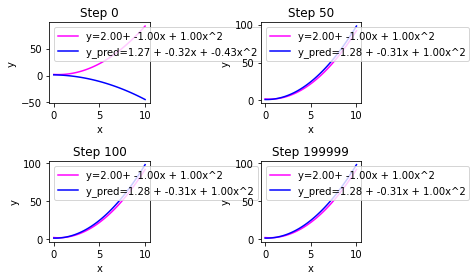

True function: y= 2 - x + x^2
Learnt function: y_pred = 1.279896855354309 + -0.3089747726917267*x + 1.0007785558700562*x^2
Model has more or less converged to true underlying function


In [4]:
# Try quadratic model architecture: y_pred = w0 + w1*x + w2*x^2
w0 = torch.randn(1, requires_grad=True)
w1 = torch.randn(1, requires_grad=True)
w2 = torch.randn(1, requires_grad=True)
# combine bias and weights matrix
params = [w0, w1, w2]

# Training: repeatative adjustment of parameters via gradient.
num_steps = 200000
learning_rate = 1e-4

plt.figure()

# Train model iteratively
i = 1
plot_steps = [0, 50, 100, 199999]

for step in range(num_steps):
  # quadratic model architecture
  y_pred = params[0] + params[1] * x + params[2] * (x ** 2)

  # Periodically plot the true function and current approximation to check how we are doing
  if step in plot_steps:
    draw_subplot(i, step, draw_parabola, {"w0": 2, "w1": -1, "w2": 1},
                 draw_parabola, {"w0": params[0].data.numpy()[0], "w1": params[1].data.numpy()[0], "w2": params[2].data.numpy()[0],
                 "color": "blue", 
                 "label": f"y_pred={params[0].data.numpy()[0]:.2f} + {params[1].data.numpy()[0]:.2f}x + {params[2].data.numpy()[0]:.2f}x^2"})
    i += 1

  # Compute Mean Squared Error (M.S.E)
  mean_squared_error = torch.mean(y_pred - y_obs) ** 2

  # Back propogate. Computes the partial derivative of error with respect to each variable and stores it within the grad field of the variable.
  mean_squared_error.backward()

  # periodically print diagnostic values every 100th iteration
  if step % 20000 == 0:
    print(f"Step {step}: \nw0 = {params[0].data} w1 = {params[1].data} w2={params[2].data}\nMSE Error = {mean_squared_error}")
    print(f"Gradient of w0: {params[0].grad} \nGradient of w1: {params[1].grad} \nGradient of w2: {params[2].grad}")

  # Crucial step, adjust the parameters (weights and bias) using the gradients (partial derivatives) computed during the call to backward() above
  update_parameters(params, learning_rate)

plt.tight_layout()
plt.show()

print("True function: y= 2 - x + x^2")
print(f"Learnt function: y_pred = {params[0].data.numpy()[0]} + {params[1].data.numpy()[0]}*x + {params[2].data.numpy()[0]}*x^2")
print("Model has more or less converged to true underlying function")